# Определение возраста покупателей

## Исследовательский анализ данных

Предварительно загрузим необходимые в работе модули.

In [15]:
# Загружаем модели
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

После этого загрузим данные из датасета.

In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на частоту распределения возраста.

In [12]:
labels['real_age'].value_counts(ascending=False).head(25)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
17    163
34    156
50    156
1     149
35    147
37    144
33    144
21    143
31    129
15    128
Name: real_age, dtype: int64

Возраст 30 и 25 лет чаще остальных представлены в выборке.

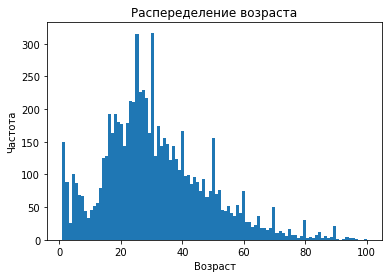

In [26]:
# Получаем все возрасты в датасете
ages = labels['real_age']

# Создаем гистограмму возрастов
plt.hist(ages, bins=100)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распеределение возраста')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Возраст')

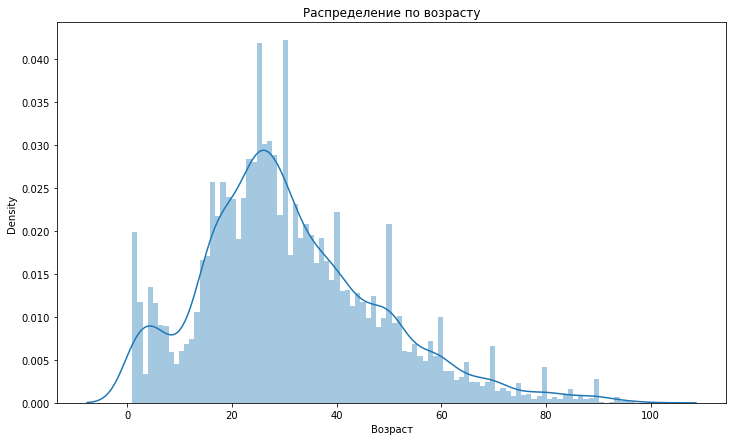

In [25]:
plt.figure(figsize=(12,7))
sns.distplot(labels['real_age'], bins=100)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')

In [ ]:
# получаем первый батч из датасета
X, y = next(train_gen_flow)

# выводим на экран первые десять фото
for i in range(10):
    plt.imshow(X[i])
    plt.show()

### Вывод по полученным данным:

- В данных нет пропусков, но возможны пустые картинки, для этого необходимо просмотреть весь датасет.
- Самый распространенный возраст - от 15 до 50 лет, при этом есть 149 фото с годовалыми младенцами.
- В датасете есть фото с аугментацией (повороты под углом).

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D \
from tensorflow.keras.models import Sequential \
from tensorflow.keras.optimizers import Adam \
from tensorflow.keras.preprocessing.image import ImageDataGenerator \
import numpy as np \
from tensorflow.keras.applications.resnet import ResNet50 \
import pandas as pd 

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path): \
    labels = pd.read_csv(path + 'labels.csv') \
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) \
    test_datagen_flow = test_datagen.flow_from_dataframe( \
        dataframe=labels, \
        directory=path + 'final_files/', \
        x_col='file_name', \
        y_col='real_age', \
        target_size=(224, 224), \
        batch_size=32, \
        class_mode='raw', \
        subset='validation', \
        seed=12345) \
    return test_datagen_flow 

def create_model(input_shape): \
    optimizer = Adam(lr = 0.0001) \
    backbone = ResNet50(input_shape=input_shape, \
                        weights='imagenet',  \
                        include_top=False) 

    model = Sequential() 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae']) 

    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None): 

    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data) 
    if validation_steps is None: 
        validation_steps = len(test_data) 

    model.fit(train_data,  
              validation_data=test_data, 
              batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2, shuffle=True) 

    return model

Train for 190 steps, validate for 48 steps \
Epoch 1/5 \
2023-01-22 13:24:01.817460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10 \
2023-01-22 13:24:02.220009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7 \
190/190 - 64s - loss: 239.8923 - mae: 10.9506 - val_loss: 886.0251 - val_mae: 24.7697 \
Epoch 2/5 \
190/190 - 44s - loss: 76.6933 - mae: 6.5617 - val_loss: 778.3466 - val_mae: 22.8575 \
Epoch 3/5 \
190/190 - 46s - loss: 51.5310 - mae: 5.4806 - val_loss: 444.0606 - val_mae: 16.2290 \
Epoch 4/5 \
190/190 - 51s - loss: 36.4776 - mae: 4.5911 - val_loss: 133.0585 - val_mae: 8.6286 \
Epoch 5/5 \
190/190 - 51s - loss: 26.8764 - mae: 3.9548 - val_loss: 76.1133 - val_mae: 6.7569

Модель обучена и преодолела планку требуемой точности

## Анализ обученной модели

Была создана нейронная сеть с использованием остаточной нейронной сети Residual Networks, также были использованы сверточные сети. Для обучения модели использовался алгоритм Adam, для которого  learning_rate был равен 0.0001.

Каждая эпоха обучалась примерно одну минуту.

На последней эпохе были получены следующие показатели средней абсолютной ошибки:

MAE на обучающей выборке - 3.9548 \
MAE на валидационной выборке - 6.7569

Данный показатель соответствует требуемому значению MAE, которое должно быть ниже 8.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы